Copyright (c) <2022>, <Regina Nockerts>
All rights reserved.

This source code is licensed under the BSD-style license found in the
LICENSE file in the root directory of this source tree. 

In [1]:
import numpy as np
import pandas as pd
import os.path
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pylab import rcParams
from torch import nn, optim
from torch.utils import data

%matplotlib inline
#%config InlineBackend.figure_format='retina'
plt.style.use('fivethirtyeight')
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
my_plot_colors = ['darkviolet','tomato', 'teal']
happy_colors = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(happy_colors))

my_seed = 42
np.random.seed(my_seed)
torch.manual_seed(my_seed)

# Import data

In [7]:
tweets_data = pd.read_csv(os.path.join('data', "tweets_clean.csv"), header=0, index_col=0)
    # NOT sure where this csv comes from. Try all_labeled_tweets.csv instead?
tweets_data.drop(['Date', 'Content', 'n_CapLetters', 'CapsRatio', 'AllCapWords', 'https', 'Mentions', 'Location', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'Hashtags', 'Labels', 'label_stance', 'y_stance', 'Flag'], inplace=True, axis=1)
tweets_data.head()

,id_stable,ContentClean,label_sent,y_sent
0,170314,Per a White House official: Biden and Harris m...,neutral,0
1,192623,Afghan Refugee kid educated in Iran wins this ...,happy,2
2,106982,Not only did Trump stop processing asylum & re...,disgust,1
3,31609,An Afghan refugee demands the US not forget he...,plea - disgust,1
4,152666,One moment you hate refugees and the next you ...,hopeful,2


In [8]:
tweets_data.y_sent.value_counts()

1    732
0    255
2    224
Name: y_sent, dtype: int64

So, I assigned the codes wrong and need to reassign them: 
0 = negative
1 = neutral
2 = positive

Name: y_sent, dtype: int64
* 1:    732
* 0:    255
* 2:    224


In [9]:
def bert_code(code):
    code = int(code)
    if code == 0:
        return 1
    elif code == 1:
        return 0
    else:
        return 2

In [10]:
tweets_data["y_bert"] = tweets_data.y_sent.apply(bert_code)

In [12]:
print(tweets_data.y_bert.value_counts())
tweets_data.head()

0    732
1    255
2    224
Name: y_bert, dtype: int64


,id_stable,ContentClean,label_sent,y_sent,y_bert
0,170314,Per a White House official: Biden and Harris m...,neutral,0,1
1,192623,Afghan Refugee kid educated in Iran wins this ...,happy,2,2
2,106982,Not only did Trump stop processing asylum & re...,disgust,1,0
3,31609,An Afghan refugee demands the US not forget he...,plea - disgust,1,0
4,152666,One moment you hate refugees and the next you ...,hopeful,2,2


### Check class distribution

0    732
1    255
2    224
Name: y_bert, dtype: int64


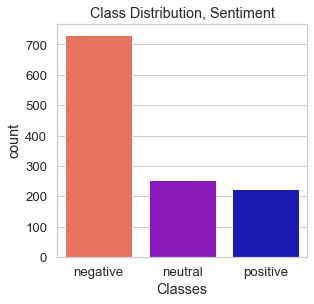

In [13]:
print(tweets_data["y_bert"].value_counts())

#plot class distribution
plt.figure(figsize=(4, 4))
plot_colors = ['tomato','darkviolet','mediumblue']
ax = sns.countplot(x=tweets_data["y_bert"], palette=plot_colors).set_xticklabels(["negative", "neutral", "positive"])
plt.xlabel('Classes')
plt.title('Class Distribution, Sentiment');

### PAUSE / UNPAUSE

In [89]:
tweets_data.to_csv("tweets_data_bert.csv")

In [ ]:
tweets_data = pd.read_csv("tweets_data_bert.csv", header=0, index_col=0)

# Balance the data

So, there are a LOT fewer positive tweets in our set than negative tweets. We will need to deal with that before using machine learning algorithms, or the models will simply learn to predict the majority class. 

I think some combination of randomly downsampling the negative *and* upsampling the neutral and positive. Not sure about generated data (google translate to German and back?).

IN ADDITION: remember that our evaluation metric will be F1 and AUC. Create a confusion matrix.

### Sentiment: Downsample negative sentiment tweets in the Training Data

**QUESTION: Can I put the unused rows back in the validation data?** ________

I don't think so: the validation set should resemble the distribution of test data/new data coming in.





----------BOOKMARK---------

Code below is untested.

In [ ]:
## Generator.permutation: which should be used for new code ##

# Make a list of the stable ids of rows that are of sentiment label 1 (negative)
# Shuffle that list and divide it in half. We can now use this as a random selection of rows to remove from the dominant class.

my_index = []
for i, label in zip(y_train_sent.id_stable, y_train_sent.y_sent):
    if label == 1:
        my_index.append(i)
print("Initial index length:", len(my_index))

rand.seed(10)
del_index = np.random.permutation(my_index) 

del_index = del_index[0:len(del_index)//2]
print("Random half length:", len(del_index))

del_index

In [ ]:
print("Sentiment, BEFORE row drop")
print("y_train:", y_train_sent.shape)
print("x_train:", x_train.shape)

for idx, stable in zip(x_train.index, x_train["id_stable"]):
    if stable in del_index:
        y_train_sent.drop(idx, axis=0, inplace=True)
        x_train.drop(idx, axis=0, inplace=True)

print()
print("Sentiment, AFTER row drop")
print("y_train:", y_train_sent.shape)
print("x_train:", x_train.shape)

# x_train = x_train.copy()
# y_train_sent = y_train_sent.copy()


In [ ]:
#plot class distribution
plt.figure(figsize=(10, 5))
sns.countplot(x=y_train_sent["y_sent"], palette='Spectral')
plt.xlabel('Classes')
plt.title('Class Distribution in Training Data, Sentiment');

In [ ]:
# Save the result.

# Replace emoji with text

# Replace extended vowels with double vowels
eg: "haaaaaaaate" becomes "haate"

Need to do this to both preserve the distinction between "hate" and *emphasized"hate", but still make it standard - "haaaaaaate" and "haaaate" are both serving the same purpose.